https://dschloe.github.io/python/python_edu/07_deeplearning/deep_learning_lstm/ 

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) # 구글 드라이브 경로

Mounted at /content/gdrive


# **데이터 로드 및 시각화**

In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/1. 시계열데이터 분석/2. VAR_ETT/ETTh1.csv')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (17420, 8)


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


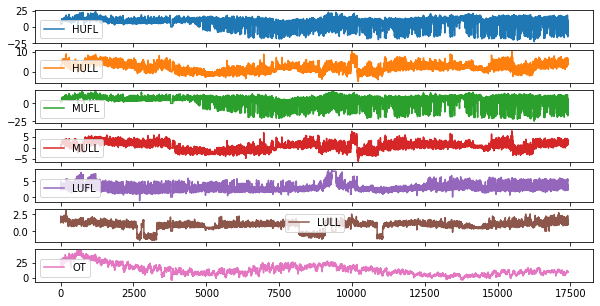

In [ ]:
# 시각화
df.plot(subplots=True, figsize=(10,5))
plt.show()

# **데이터 전처리**

In [ ]:
# ----- 데이터 수, 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    17420 non-null  object 
 1   HUFL    17420 non-null  float64
 2   HULL    17420 non-null  float64
 3   MUFL    17420 non-null  float64
 4   MULL    17420 non-null  float64
 5   LUFL    17420 non-null  float64
 6   LULL    17420 non-null  float64
 7   OT      17420 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.1+ MB


In [ ]:
# ----- 데이터의 통계적 특성
stats = df.describe()
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
HUFL,17420.0,7.375141,7.067744,-22.705999,5.827,8.774,11.788,23.643999
HULL,17420.0,2.242242,2.042342,-4.756000,0.737,2.210,3.684,10.114000
MUFL,17420.0,4.300239,6.826978,-25.087999,3.296,5.970,8.635,17.341000
MULL,17420.0,0.881568,1.809293,-5.934000,-0.284,0.959,2.203,7.747000
LUFL,17420.0,3.066062,1.164506,-1.188000,2.315,2.833,3.625,8.498000
LULL,17420.0,0.856932,0.599552,-1.371000,0.670,0.975,1.218,3.046000
OT,17420.0,13.324672,8.566946,-4.080000,6.964,11.396,18.079,46.007000


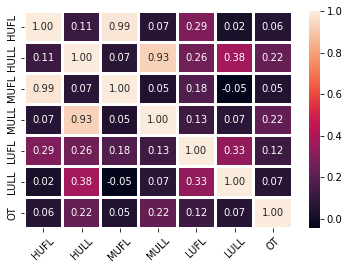

In [ ]:
# ----- 피어슨 상관관계 분석
heat_map = sns.heatmap(df.corr(method='pearson'), annot=True, fmt='.2f', linewidths=2)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=45);

### **특징이 되는 데이터 추출**

In [ ]:
# input_feature = df.iloc[:,[2,7]].values # HULL, OT
input_feature = df.iloc[:,[7]].values # OT
input_data = input_feature

In [ ]:
len(input_data)

17420

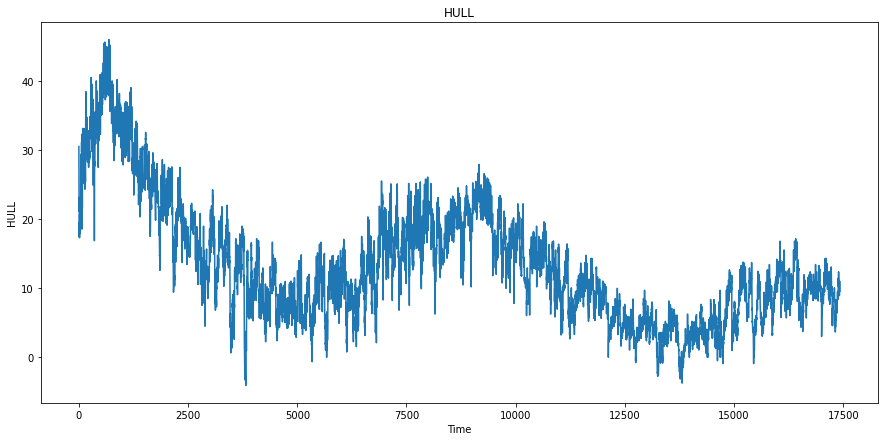

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(input_feature[:,0])
plt.title("HULL")
plt.xlabel("Time")
plt.ylabel("HULL")
plt.show()

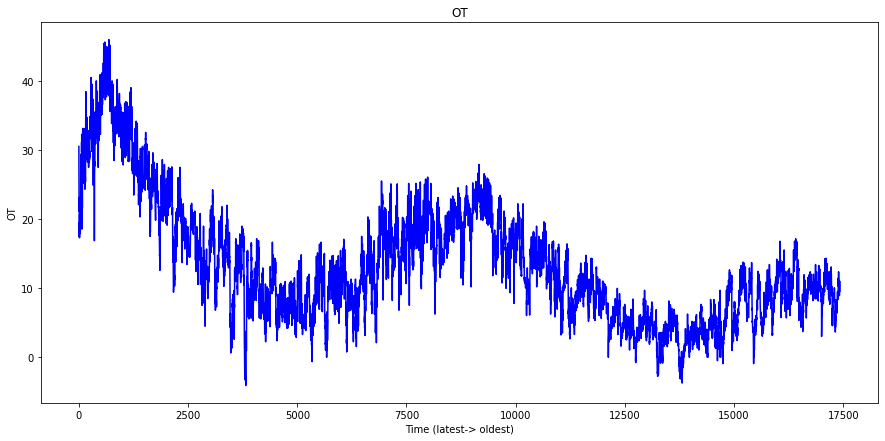

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(input_data, color='blue')
plt.title("OT")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("OT")
plt.show()

# **데이터 정규화**

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc= MinMaxScaler(feature_range=(0,1))
# input_data[:,0:2] = sc.fit_transform(input_feature[:,:])
input_data[:,:] = sc.fit_transform(input_feature[:,:])

In [ ]:
input_data = pd.DataFrame(input_data)
input_data.columns = ['OT']
input_data

,OT
0,0.691018
1,0.636233
2,0.636233
3,0.581468
4,0.519656
...,...
17415,0.299159
17416,0.301955
17417,0.286521
17418,0.276679


# **Train, Test 데이터 분리**

In [ ]:
TEST_SIZE = int(len(input_data)*0.2) # TEST 데이터 20%.
WINDOW_SIZE = 24 # 과거 24시간 기반으로 내일 데이터를 예측

train = input_data[:-TEST_SIZE] # 13936. 과거 13936 시간 이전의 데이터를 학습
test = input_data[-TEST_SIZE:] # 3484. 이후 3484 시간 이후의 데이터를 예측
train.shape, test.shape

((13936, 1), (3484, 1))

## **train 데이터 생성**

In [ ]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        # print("i, window_size, i+window_size:",i, window_size, i+window_size) #0,20,20 / 1,20,21 ~ 17399,20,17419
        # label_list.append(np.array(label.iloc[i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size-1]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
from sklearn.model_selection import train_test_split

train_feature = train
train_label = train

x_train, y_train = make_dataset(train_feature, train_label, WINDOW_SIZE)
x_train.shape, y_train.shape

((13912, 24, 1), (13912, 1))

In [ ]:
i = 0
train_feature.iloc[i:i+WINDOW_SIZE]

,OT
0,0.691018
1,0.636233
2,0.636233
3,0.581468
4,0.519656
5,0.504203
6,0.536506
7,0.543534
8,0.514046
9,0.429772


In [ ]:
train_label.iloc[i+WINDOW_SIZE-1].head()

OT    0.476132
Name: 23, dtype: float64

## **test 데이터 생성**

In [ ]:
test_feature = test
test_label = test

print(test_feature.shape, test_label.shape)

x_test, y_test = make_dataset(test_feature, test_label, WINDOW_SIZE)
print(x_test.shape, y_test.shape)

(3484, 1) (3484, 1)
(3460, 24, 1) (3460, 1)


In [ ]:
x_train.shape[1], x_train.shape[2]

(24, 1)

# **모델 생성 및 학습**

In [ ]:
model = Sequential()

## 50개 뉴런, 4개층
#Adding the 1 LSTM layer and some Dropout regularisation
model.add(LSTM(units = 128, return_sequences = True, 
               activation="tanh",
               input_shape = (x_train.shape[1], x_train.shape[2]))) #20, 1
model.add(Dropout(0.2))

# 2 layer
model.add(LSTM(units = 64))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

model.compile(optimizer ='adam', loss ='mse',metrics=['mae','mse','accuracy'])
model.summary()

history = model.fit(x_train, y_train, epochs = 20, batch_size = 32, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 128)           66560     
                                                                 
 dropout_2 (Dropout)         (None, 24, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
348/348 [============================

In [ ]:
# model.save('/content/gdrive/MyDrive/1. RNN/LSTM 연습.h5')

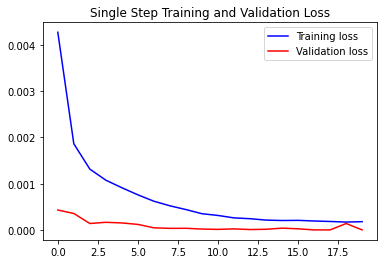

In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

plot_train_history(history,
                   'Single Step Training and Validation Loss')

# **결과 시각화**

In [ ]:
pred = model.predict(x_test)
pred.shape

(3460, 1)

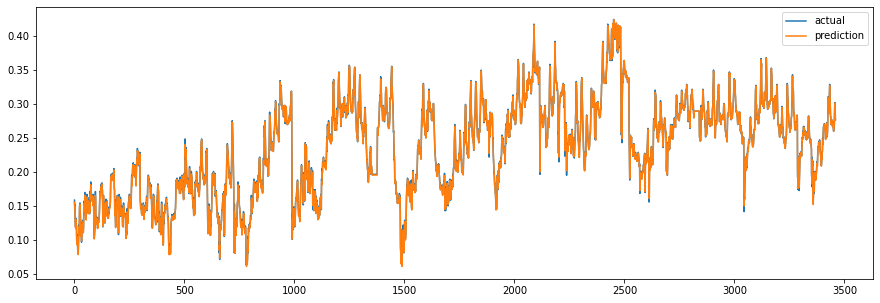

In [ ]:
# ----- t 시점
plt.figure(figsize=(15,5))
plt.plot(y_test, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

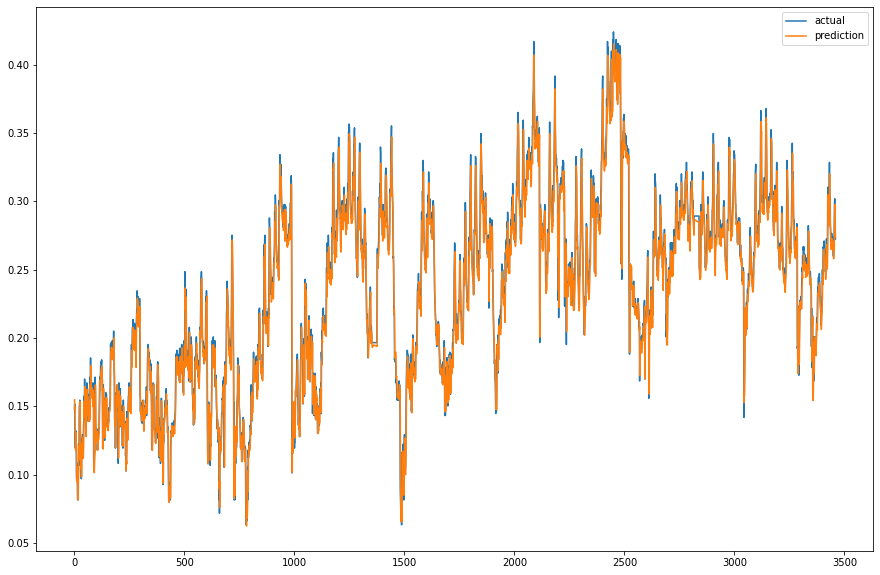

In [ ]:
# ----- t+1 시점
plt.figure(figsize=(15,5))
plt.plot(y_test, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

## **정규화된 데이터 복구**

In [ ]:
pred_inverse = sc.inverse_transform(pred)

In [ ]:
y_test_inverse = sc.inverse_transform(y_test)

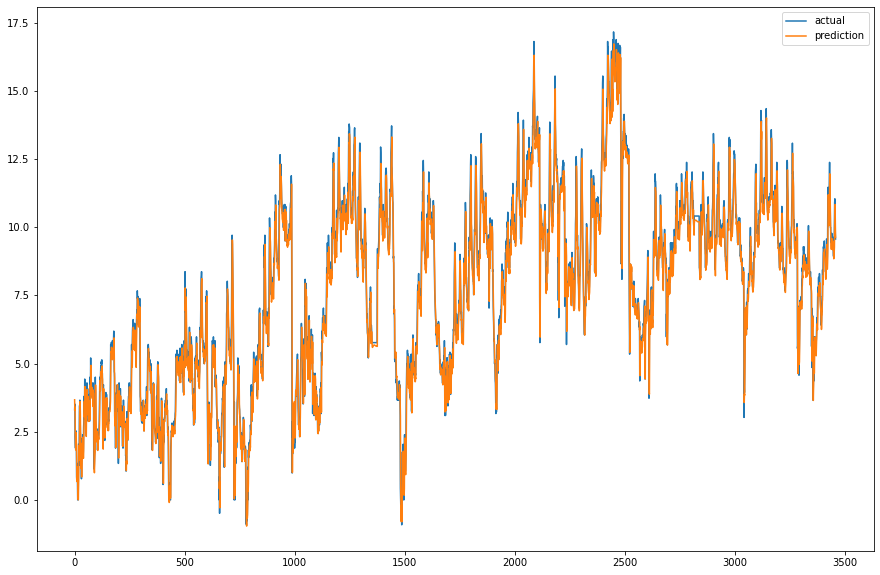

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test_inverse, label = 'actual')
plt.plot(pred_inverse, label = 'prediction')
plt.legend()
plt.show()

In [ ]:
# ----- t 시점
from sklearn.metrics import mean_squared_error


print("----RMSE----")
rmse_ot = round(mean_squared_error(y_test_inverse, pred_inverse)**0.5,2)
print("OT     ",rmse_ot)

print("----MSE----")
mse_ot = round(mean_squared_error(y_test_inverse, pred_inverse),2)
print("OT     ",mse_ot)


----RMSE----
OT      0.09
----MSE----
OT      0.01


In [ ]:
# ----- t+1 시점
from sklearn.metrics import mean_squared_error


print("----RMSE----")
rmse_ot = round(mean_squared_error(y_test_inverse, pred_inverse)**0.5,2)
print("OT     ",rmse_ot)

print("----MSE----")
mse_ot = round(mean_squared_error(y_test_inverse, pred_inverse),2)
print("OT     ",mse_ot)


----RMSE----
OT      0.67
----MSE----
OT      0.45


1. 데이터 로드 (csv 파일)
2. EDA
    - 결측치 확인
    - 통계적 특성 확인(describe)
    - 필드별 이상치 확인(박스 플롯)
    - 상관관계 분석
    + 의사 결정 트리, DNN
3. featuring Input data (특징이 있는 데이터를 골라 입력 데이터로)
4. 데이터 정규화
5. train, test 데이터 분리
6. convert input data
   - (test data수, 시점, input feature 수)

